* **Soil Liquefaction** occurs when soil usually behaving like a "solid" acts like a "liquid", due to sudden change in stress conditions. Earthquakes are primary causes of liquefaction. 

* In this notebook, we train a logistic regression model to *predict if the soil will liquefy or not* for a given set of conditions (earthquake parameters and soil characteristics).

* **Data from**: Jilei Hu, Jing Wang, Wenjun Zou, Bing Yang, Datasets for gravelly soil liquefaction case histories, Data in Brief, Volume 36, 2021, 107104, ISSN 2352-3409

In [74]:
# logistic regression

# using LoR to convert 'categorical' data to numeric
# sigmoid fxn matches the 0 or 1 value characteristic
# y=1/[1+e−(w⋅x+b)]
# but we can transform it into linear as ln(y/1−y)=w⋅x+b where LHS is called "logit" (logistic unit) for "probability"  y .

import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import brier_score_loss, log_loss, zero_one_loss
import numpy as np
import seaborn as sns

PROJECT_ROOT = Path.cwd().parent
RAW_DATA_DIR = PROJECT_ROOT / 'data' / 'raw'
RAW_DATA_DIR.mkdir(parents=True, exist_ok=True)

xls_path = RAW_DATA_DIR / 'soil-liquefaction.xlsx'
df_raw = pd.read_excel(xls_path)

df = df_raw.copy()



High Correlations (|r| > 0.9):
depth_to_soil_layer  effective_stress    0.913198
dtype: float64


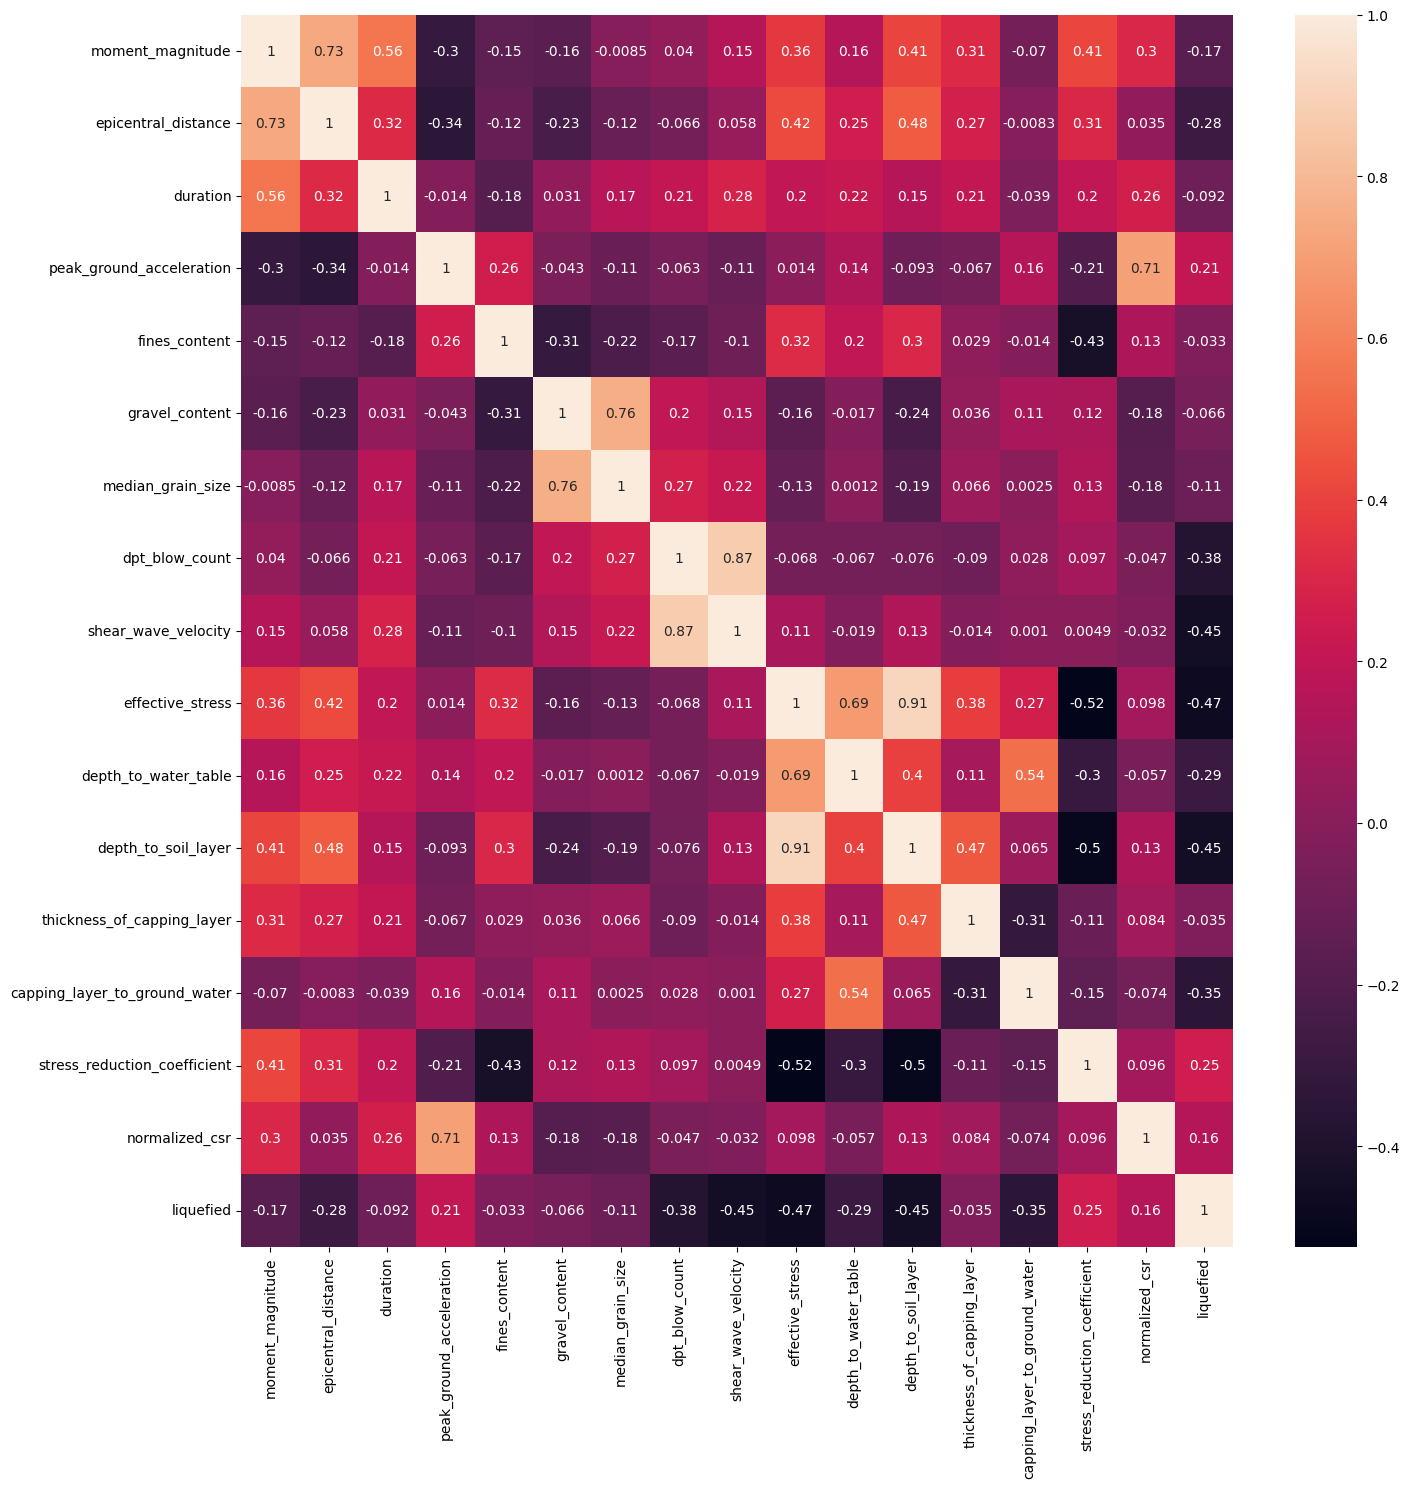

In [75]:
# preprocess

# renaming columns for clarity
df.rename(columns = {
  'Mw': 'moment_magnitude',
  'R (km)': 'epicentral_distance',
  't (s)': 'duration',
  'PGA': 'peak_ground_acceleration',
  'FC (%)': 'fines_content',
  'GC (%)': 'gravel_content',
  'D50 (mm)': 'median_grain_size',
  'N\'120': 'dpt_blow_count',
  'Vs1 (m/s)': 'shear_wave_velocity',
  'σ\'v (kPa)': 'effective_stress',
  'Dw (m)': 'depth_to_water_table',
  'Ds (m)': 'depth_to_soil_layer',
  'Hn (m)': 'thickness_of_capping_layer',
  'Dn (m)': 'capping_layer_to_ground_water',
  'rd': 'stress_reduction_coefficient',
  'CSR7.5': 'normalized_csr',
  'Liqefied ？': 'liquefied'
}, inplace = True)

# remove unnecessary columns
df.drop(columns = [
  'Case No.',
  'Date',
  'Earthquake Name',
  'Site location & Borehole name',
  'MSF',
  'CSR',
  'Reference'
], inplace = True)

# convert the "liquefied" column to True and False
df['liquefied'] = (df['liquefied'] == "Yes")

# preview the data frame
#display(df.head(5))

# info method shows non-null counts and data types for all columns (we have few missing)
#display(df.info())


correlation_matrix = df.corr()

plt.figure(figsize = (16, 16))
sns.heatmap(correlation_matrix, annot = True)

mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))  # Upper triangle only
high_corr = correlation_matrix.where(~mask).stack()  # Remove upper triangle + diagonal
high_corr = high_corr[high_corr.abs() > 0.9].sort_values(ascending=False)

print("\nHigh Correlations (|r| > 0.9):")
print(high_corr)

In [76]:
# remove highly corr
df.drop(
  columns = ['effective_stress', 'shear_wave_velocity'],
  inplace = True
)

#df.info()

# columns with null values are:
# 1. epicentral_distance, duration -> high correlation with moment_magnitude
#    replace with the "median" of values with same "moment_magnitude"
# 2. fines_content, gravel_content, median_grain_size
#    replace with -1 to indicate missing value
# 3. thickness_of_capping_layer and capping_layer_to_ground_water
#    replace with 0


filtered_df = df[['moment_magnitude', 'epicentral_distance', 'duration']]

# values with same moment_magnitude
medians = filtered_df.groupby('moment_magnitude').median()


# null indices
indices = filtered_df.index[filtered_df.isnull().any(axis = 1)]

for index in indices:
  median_moment_magnitude = df.loc[index, 'moment_magnitude']
  median_row = medians.query(f'index == {median_moment_magnitude}')

  df.loc[index, 'epicentral_distance'] = median_row.iloc[0, 0]
  df.loc[index, 'duration'] = median_row.iloc[0, 1]

# replace missing fines_content, gravel_content and median_grain_size with -1
df.fillna({
  'fines_content': -1,
  'gravel_content': -1,
  'median_grain_size': -1,
  'thickness_of_capping_layer': 0,
  'capping_layer_to_ground_water': 0
}, inplace = True)

# display(df.info()) #imputation; all non null done


In [77]:
# make std pipeline for ml

column_names = df.columns

# in binary classification the "target" should be "binary"
# in our case it is "Yes" or "No"
target = 'liquefied'
features = column_names[column_names != target]

X = df[features] # feature vectors
y = df[target] # target

# 20% of the data to be used for testing
# stratify = ...
X_train, X_test, y_train, y_test = train_test_split(
  X,
  y,
  test_size = 0.2,
  stratify = y # IMPORTANT: BOTH CASES (True, False) SHOULD BE INCLUDED
)

print(f"Training Set: {len(y_train)}/{len(df)}")
print(f"Testing Set: {len(y_test)}/{len(df)}")



Training Set: 187/234
Testing Set: 47/234


In [78]:
# to improve numeric stability -> reduce all columns to mean of 0 and variance of 1; x-mu/stdev
pipe = make_pipeline(StandardScaler(), LogisticRegression(random_state=42)).fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print(f'Mean Accuracy (Average of predicted == actual) = {score:.3f}')

predicted_liquefied = pipe.predict(X_test)

bscore = brier_score_loss(y_test, predicted_liquefied)
logloss = log_loss(y_test, predicted_liquefied)
zeroneloss = zero_one_loss(y_test, predicted_liquefied)

print(f'Brier Score: {bscore:.2f}, Log Loss: {logloss:.2f}, 0-1 Loss: {zeroneloss:.2f}')

Mean Accuracy (Average of predicted == actual) = 0.936
Brier Score: 0.06, Log Loss: 2.30, 0-1 Loss: 0.06


In [ ]:
real_data = y_test
predicted_data = predicted_liquefied

# TODO: calculate the number of items where real_data != predicted_data

number_of_mismatches = (y_test != predicted_data).sum() # vectorize instead of loop

# Test the mean accuracy
mean_accuracy = 1 - number_of_mismatches / len(y_test)

print(f"Mean Accuracy = {score:.2f} | Computed = {mean_accuracy:.2f}")

Mean Accuracy = 0.94 | Computed = 0.94


In [80]:
# assume the soil will not liquefy only if P(False) > 60%

# Step 1: Extract ONE test sample (first row of X_test)
test_row = X_test[:1]
# X_test[:1] is a DataFrame with shape (1, 16) — ONE soil sample with 16 features
# (earthquake params + soil characteristics)

# Step 2: Get PROBABILITY prediction (not just True/False)
predicted_probabilities = pipe.predict_proba(test_row)
# Output: [[P(False), P(True)]]
# Example: [[0.35, 0.65]] means 35% chance NO liquefaction, 65% chance YES liquefaction

# Step 3: Show the probabilities
display(predicted_probabilities)
# Displays: [[0.35, 0.65]]

# Step 4: Show the HARD prediction (True/False) for this sample
display(predicted_data[:1])
# Displays: [True] — model says "LIQUEFACTION WILL OCCUR"

# Step 5: Show the ACTUAL ground truth for this sample
display(y_test[:1])
# Displays: [True] — in reality, liquefaction DID occur
# So the model got it RIGHT for this sample

array([[0.0502672, 0.9497328]])

array([ True])

115    True
Name: liquefied, dtype: bool